# Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
clean_data = 'clean_medical_insurance_cost.csv'

df = pd.read_csv(clean_data)
df.head()

,age,sex,bmi,children,smoker,region,charges,weight_status,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,2.Overweight,19-34
1,18,male,33.770,1,no,southeast,1725.55230,3.Obese,18-19
2,28,male,33.000,3,no,southeast,4449.46200,3.Obese,19-34
3,33,male,22.705,0,no,northwest,21984.47061,1.Normal,19-34
4,32,male,28.880,0,no,northwest,3866.85520,2.Overweight,19-34


# 1. Feature Engineer ( Create Dummy features)

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges,weight_status,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,2.Overweight,19-34
1,18,male,33.770,1,no,southeast,1725.55230,3.Obese,18-19
2,28,male,33.000,3,no,southeast,4449.46200,3.Obese,19-34
3,33,male,22.705,0,no,northwest,21984.47061,1.Normal,19-34
4,32,male,28.880,0,no,northwest,3866.85520,2.Overweight,19-34


In [4]:
def encode_and_concat(org_df, feature_to_encode):
    '''
    Convert a catergorical feature into one hot encode, 
    concat the encode columns to the original dataframe, and delete the categorical column
    @return: a dataframe with one hot encode columns
    '''
    dummies = pd.get_dummies(org_df[[feature_to_encode]])
    res = pd.concat([org_df, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

features_to_encode = ['sex', 'smoker', 'children', 'region', 'weight_status', 'age_group']

for feature in features_to_encode:
    df = encode_and_concat(df, feature)
    
df.head()

,age,bmi,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,weight_status_0.Underweight,weight_status_1.Normal,weight_status_2.Overweight,weight_status_3.Obese,age_group_18-19,age_group_19-34,age_group_35-44,age_group_45-54,age_group_55-64
0,19,27.900,16884.92400,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
1,18,33.770,1725.55230,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0
2,28,33.000,4449.46200,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,33,22.705,21984.47061,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,32,28.880,3866.85520,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [5]:
df.isnull().sum()

age                            0
bmi                            0
charges                        0
sex_female                     0
sex_male                       0
smoker_no                      0
smoker_yes                     0
region_northeast               0
region_northwest               0
region_southeast               0
region_southwest               0
weight_status_0.Underweight    0
weight_status_1.Normal         0
weight_status_2.Overweight     0
weight_status_3.Obese          0
age_group_18-19                0
age_group_19-34                0
age_group_35-44                0
age_group_45-54                0
age_group_55-64                0
dtype: int64

# 3. Train and Test Split

In [6]:
# Target feature is 'charges', random state: to make sure return the same result everytime I run the code
X = df.drop(columns='charges')     # return the new dataframe
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

print(f'Shape of X_train = {X_train.shape}, X_test = {X_test.shape}')
print(f'Shape of y_train = {y_train.shape}, y_test = {y_test.shape}')

Shape of X_train = (1070, 19), X_test = (268, 19)
Shape of y_train = (1070,), y_test = (268,)


In [7]:
print(X_train.dtypes)
print(X_test.dtypes)

age                              int64
bmi                            float64
sex_female                       uint8
sex_male                         uint8
smoker_no                        uint8
smoker_yes                       uint8
region_northeast                 uint8
region_northwest                 uint8
region_southeast                 uint8
region_southwest                 uint8
weight_status_0.Underweight      uint8
weight_status_1.Normal           uint8
weight_status_2.Overweight       uint8
weight_status_3.Obese            uint8
age_group_18-19                  uint8
age_group_19-34                  uint8
age_group_35-44                  uint8
age_group_45-54                  uint8
age_group_55-64                  uint8
dtype: object
age                              int64
bmi                            float64
sex_female                       uint8
sex_male                         uint8
smoker_no                        uint8
smoker_yes                       uint8
region_nort

# 4. Modeling

In [8]:
r2_results = {}
mae_results = {}
mse_results = {}
rmse_results = {}

# Not even a model

In [9]:
train_mean = y_train.mean()
print(f'On the training set, the average medical insurance cost for each person is: {train_mean}')

On the training set, the average medical insurance cost for each person is: 13313.097859830857


In [10]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[13313.09785983]])

### 3.1.1 R-square

In [11]:
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = dumb_reg.predict(X_test)

r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0002965633114575539)

## 4.1 - Model 1: Linear Regression 

In [12]:
# Train the linear regression model with training set
reg = LinearRegression().fit(X_train, y_train)

print(f'The intercept: {reg.intercept_}')
print(f'The slope: {reg.coef_}')

The intercept: 4695.569873000928
The slope: [   253.54647415    149.41059943    156.11107565   -156.11107565
 -11887.0447214   11887.0447214     308.06600589    504.09246533
   -449.06561769   -363.09285353  -1459.29018313   -365.55318104
   -468.96840064   2293.81176482   -310.91311519    266.18895643
   -721.07137085     38.93079404    726.86473558]


In [13]:
y_pred = reg.predict(X_test)

In [14]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
1062,48970.24760,40104.108437
684,4766.02200,3633.308885
907,7633.72060,10076.294652
102,21344.84670,4318.937619
1067,5757.41345,10794.642086
...,...,...
1016,2709.24395,1862.995276
961,3353.28400,3621.346205
1312,4536.25900,9879.616780
856,40974.16490,35739.618317


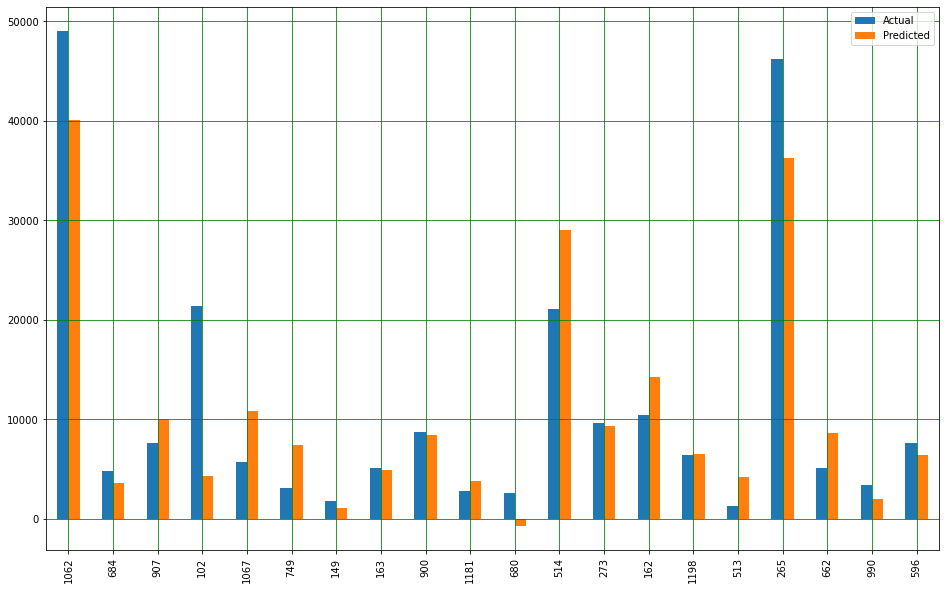

In [15]:
df1 = df.head(20)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(linestyle='-', color='green')
plt.show()

In [16]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2_score ', r2_score(y_test, y_pred))

Mean Absolute Error: 3995.8392706925983
Mean Squared Error: 30734573.72447429
Root Mean Squared Error: 5543.877138291783
R2_score  0.7992096604762513


## Scale and use Linear Regression model

### Default k = 'all'

In [17]:
# Define the pipeline
pipe = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler(),
            SelectKBest(f_regression, k='all'),
            LinearRegression()
        )

# Fit the pipeline
pipe.fit(X_train, y_train)

# Access performance on the train and test set
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

print(r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred))
print(mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))

0.7425423863678835 0.7992096604762515
4302.923720000725 3995.8392706926


In [18]:
df = pd.DataFrame({'Actual': y_train, 'Predicted': y_tr_pred})
df

,Actual,Predicted
75,11356.6609,15710.786555
170,13405.3903,17393.510388
1049,39727.6140,35436.717980
955,3875.7341,8523.514450
564,2801.2588,3861.374248
...,...,...
691,8068.1850,11947.411766
584,1242.8160,100.139415
1288,38344.5660,29581.118487
327,42760.5022,36123.428547


### k = 3

In [19]:
# Define the pipeline
pipe2 = make_pipeline(
            StandardScaler(),
            SelectKBest(f_regression, k=3),
            LinearRegression()
        )

# Fit the pipeline
pipe2.fit(X_train, y_train)

# Access performance on the train and test set
y_tr_pred2 = pipe2.predict(X_train)
y_te_pred2 = pipe2.predict(X_test)

print(r2_score(y_train, y_tr_pred2), r2_score(y_test, y_te_pred2))
print(mean_absolute_error(y_train, y_tr_pred2), mean_absolute_error(y_test, y_te_pred2))

0.7097027354527785 0.7649281843771802
4205.787053519397 4005.8854751296935


In [20]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [21]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [22]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [23]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x7f94e33980d0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19]})

In [24]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 7}

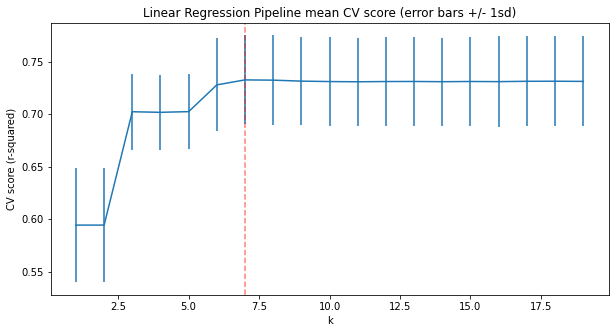

In [25]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Linear Regression Pipeline mean CV score (error bars +/- 1sd)');

## Linear regression pipeline with the best k 

In [26]:
print('------------- Linear regression -------------')

# Define the pipeline
LR_pipe = LR_pipe = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler(), 
            SelectKBest(f_regression, k=7),
            LinearRegression()
            )

# Fit the pipeline
LR_pipe.fit(X_train, y_train)

# Access performance on the train and test set
y_tr_pred = LR_pipe.predict(X_train)
y_te_pred = LR_pipe.predict(X_test)

print("Training set: ")
print(f"\t r2_scorer_training_set = {r2_score(y_train, y_tr_pred)}")
print(f"\t Mean Absolute Error (train): {mean_absolute_error(y_train, y_tr_pred)}")
print("Testing set: ")
print(f"\t r2_scorer_testing_set = {r2_score(y_test, y_te_pred)}")
print(f"\t Mean Absolute Error (test): {mean_absolute_error(y_test, y_te_pred)}")


# Hyperparameter search using GridSearchCV, Set all the parameters options for different modules
k = [k+1 for k in range(len(X_train.columns))]
lr_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(LR_pipe, param_grid=lr_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)
print(f"Best paramaters: \n{lr_grid_cv.best_params_}")



# Cross Validation with GridSearch
LR_Result = cross_val_score(lr_grid_cv, X, y, cv=5, n_jobs=-1, scoring="r2")

print()
print(LR_Result)
print('Mean: ', LR_Result.mean())
print('Standard Deviation: ', LR_Result.std())


# PREDICT
lr_predict = lr_grid_cv.predict(X_test)
score_lr = r2_score(y_test, lr_predict)

print("r_square score --> ", score_lr)
print('Mean Absolute Error -->', mean_absolute_error(y_test, lr_predict))
print('Mean Squared Error -->', mean_squared_error(y_test, lr_predict))
print('Root Mean Squared Error -->', np.sqrt(mean_squared_error(y_test, lr_predict)))

r2_results['Linear Regression'] = r2_score(y_test, lr_predict)
mae_results['Linear Regression'] = mean_absolute_error(y_test, lr_predict)
mse_results['Linear Regression'] = mean_squared_error(y_test, lr_predict)
rmse_results['Linear Regression'] = np.sqrt(mean_squared_error(y_test, lr_predict))

------------- Linear regression -------------
Training set: 
	 r2_scorer_training_set = 0.7408681573218523
	 Mean Absolute Error (train): 4303.9132956705935
Testing set: 
	 r2_scorer_testing_set = 0.799771331443163
	 Mean Absolute Error (test): 4008.447484364947
Best paramaters: 
{'selectkbest__k': 7}

[0.76775101 0.71201963 0.77482171 0.73235779 0.76130542]
Mean:  0.7496511117670066
Standard Deviation:  0.02371571661724404
r_square score -->  0.799771331443163
Mean Absolute Error --> 4008.447484364947
Mean Squared Error --> 30648599.878409833
Root Mean Squared Error --> 5536.117762332177


#### Find the coef ~ Important Features for for linear regression model

In [27]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

smoker_yes               4761.258019
age                      3802.543660
weight_status_3.Obese    1387.002778
bmi                       823.320057
age_group_19-34           404.051919
age_group_55-64           301.322419
smoker_no               -4761.258019
dtype: float64

## 4.2 Model 2 - Random Forest

In [28]:
print('------------- Random Forest -------------')

# Define the pipeline
RF_pipe = make_pipeline(SimpleImputer(strategy='median'),
                        StandardScaler(),
                        RandomForestRegressor(random_state=47)
                        )

# Fit the pipeline
RF_pipe.fit(X_train, y_train)

# Access performance on the train and test set
y_tr_pred = RF_pipe.predict(X_train)
y_te_pred = RF_pipe.predict(X_test)

print("Training set: ")
print(f"\t r2_scorer_training_set = {r2_score(y_train, y_tr_pred)}")
print(f"\t Mean Absolute Error (train): {mean_absolute_error(y_train, y_tr_pred)}")
print("Testing set: ")
print(f"\t r2_scorer_testing_set = {r2_score(y_test, y_te_pred)}")
print(f"\t Mean Absolute Error (test): {mean_absolute_error(y_test, y_te_pred)}")


# Hyperparameter search using GridSearchCV, Set all the parameters options for different modules
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rf_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}

rf_grid_cv = GridSearchCV(RF_pipe, param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(f"Best paramaters: \n{rf_grid_cv.best_params_}")



# Cross Validation with GridSearch
RF_Result = cross_val_score(rf_grid_cv, X, y, cv=5, n_jobs=-1, scoring="r2")

print()
print(RF_Result)
print('Mean: ', RF_Result.mean())
print('Standard Deviation: ', RF_Result.std())


# PREDICT
rf_predict = rf_grid_cv.predict(X_test)
score_rf = r2_score(y_test, rf_predict)

print("r_square score --> ",score_rf)
print('Mean Absolute Error -->', mean_absolute_error(y_test, rf_predict))
print('Mean Squared Error -->', mean_squared_error(y_test, rf_predict))
print('Root Mean Squared Error -->', np.sqrt(mean_squared_error(y_test, rf_predict)))

r2_results['Random Forest'] = r2_score(y_test, rf_predict)
mae_results['Random Forest'] = mean_absolute_error(y_test, rf_predict)
mse_results['Random Forest'] = mean_squared_error(y_test, rf_predict)
rmse_results['Random Forest'] = np.sqrt(mean_squared_error(y_test, rf_predict))

------------- Random Forest -------------
Training set: 
	 r2_scorer_training_set = 0.972800998812773
	 Mean Absolute Error (train): 1101.8459259471122
Testing set: 
	 r2_scorer_testing_set = 0.859919357056692
	 Mean Absolute Error (test): 2750.8058201621134
Best paramaters: 
{'randomforestregressor__n_estimators': 1000, 'simpleimputer__strategy': 'mean', 'standardscaler': StandardScaler()}

[0.85160621 0.7654838  0.85330005 0.8159129  0.84961574]
Mean:  0.8271837396255677
Standard Deviation:  0.033810138097217356
r_square score -->  0.8608328233026049
Mean Absolute Error --> 2736.647823897792
Mean Squared Error --> 21302040.04026366
Root Mean Squared Error --> 4615.413311964992


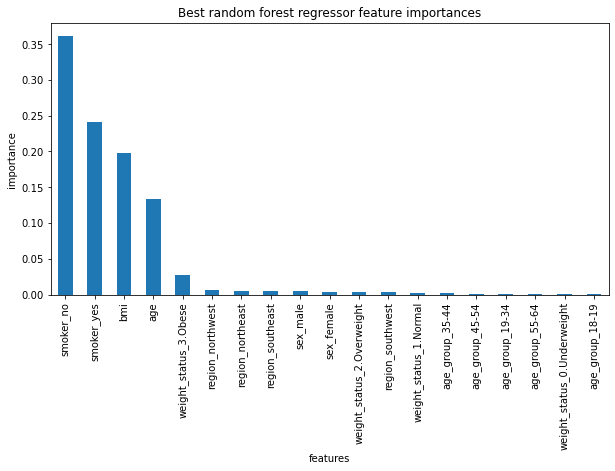

In [29]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

## Model 3:  LASSO Regression

In [30]:
print('------------- LASSO Regression -------------')

# Define the pipeline
LASSO_pipe = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler(),
            decomposition.PCA(), 
            Lasso()
        )

# Fit the pipeline
LASSO_pipe.fit(X_train, y_train)

# Access performance on the train and test set
y_tr_pred = LASSO_pipe.predict(X_train)
y_te_pred = LASSO_pipe.predict(X_test)

print("Training set: ")
print(f"\t R_square score = {r2_score(y_train, y_tr_pred)}")
print(f"\t Mean Absolute Error : {mean_absolute_error(y_train, y_tr_pred)}")
print(f'\t Mean Squared Error: ', mean_squared_error(y_train, y_tr_pred))
print(f'\t Root Mean Squared Error: ', np.sqrt(mean_squared_error(y_train, y_tr_pred)))

print("Testing set: ")
print(f"\t R_square score = {r2_score(y_test, y_te_pred)}")
print(f"\t Mean Absolute Error : {mean_absolute_error(y_test, y_te_pred)}")
print(f'\t Mean Squared Error: ', mean_squared_error(y_test, y_te_pred))
print(f'\t Root Mean Squared Error: ', np.sqrt(mean_squared_error(y_test, y_te_pred)))


# Hyperparameter search using GridSearchCV, Set all the parameters options for different modules
n_components = list(range(1,X.shape[1]+1,1))
normalize = [True, False]
selection = ["cyclic", "random"]
                                    
lasso_params = dict(pca__n_components=n_components,
                  lasso__normalize=normalize,
                  lasso__selection=selection)

lasso_grid_cv = GridSearchCV(LASSO_pipe, param_grid=lasso_params, cv=5, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(f"Best paramaters: \n\t{lasso_grid_cv.best_params_}")


# Cross Validation
LASSO_Result = cross_val_score(lasso_grid_cv, X, y, cv=5, n_jobs=-1, scoring="r2")

print()
print(LASSO_Result)
print('Mean: ', LASSO_Result.mean())
print('Standard Deviation: ', LASSO_Result.std())

# PREDICT
lasso_predict = lasso_grid_cv.predict(X_test)
score_lasso = r2_score(y_test, lasso_predict)

print("r_square score --> ",score_lasso)
print('Mean Absolute Error -->', mean_absolute_error(y_test, lasso_predict))
print('Mean Squared Error -->', mean_squared_error(y_test, lasso_predict))
print('Root Mean Squared Error -->', np.sqrt(mean_squared_error(y_test, lasso_predict)))

r2_results['Lasso Regression'] = r2_score(y_test, lasso_predict)
mae_results['Lasso Regression'] = mean_absolute_error(y_test, lasso_predict)
mse_results['Lasso Regression'] = mean_squared_error(y_test, lasso_predict)
rmse_results['Lasso Regression'] = np.sqrt(mean_squared_error(y_test, lasso_predict))

------------- LASSO Regression -------------
Training set: 
	 R_square score = 0.7425421043469583
	 Mean Absolute Error : 4302.426571903459
	 Mean Squared Error:  37305473.73937014
	 Root Mean Squared Error:  6107.820702948813
Testing set: 
	 R_square score = 0.7992775066820212
	 Mean Absolute Error : 3994.71631380397
	 Mean Squared Error:  30724188.642113727
	 Root Mean Squared Error:  5542.940432849133
Best paramaters: 
	{'lasso__normalize': True, 'lasso__selection': 'random', 'pca__n_components': 16}

[0.76281396 0.70687896 0.76828362 0.73913154 0.76224779]
Mean:  0.7478711751685438
Standard Deviation:  0.022818345695119313
r_square score -->  0.7968570866938027
Mean Absolute Error --> 4021.4518829875665
Mean Squared Error --> 31094677.465174332
Root Mean Squared Error --> 5576.260168354264


In [31]:
LASSO_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'pca', 'lasso', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

# Metric model Evaluation

In [32]:
df_r2 = pd.DataFrame.from_dict(r2_results, orient='index', columns=['R2'])
df_mae = pd.DataFrame.from_dict(mae_results, orient='index', columns=['Mean Absolute Error'])
df_mse = pd.DataFrame.from_dict(mse_results, orient='index', columns=['Mean Squared Error'])
df_rmse = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['Root Mean Squared Error'])

In [33]:
pd.concat([df_r2, df_mae, df_mse, df_rmse], axis=1)

,R2,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
Linear Regression,0.799771,4008.447484,3.064860e+07,5536.117762
Random Forest,0.860833,2736.647824,2.130204e+07,4615.413312
Lasso Regression,0.796857,4021.451883,3.109468e+07,5576.260168
